# When do individual donors donate?

Let's summarize *all* invidivual donations from the 2020 election cycle to any of a small number of TRUMP-facing committees.  *When* do people donate? Can we make individuals more effective simply by shifting their donation earlier?

In [1]:
# ruff: noqa
trump_committee_ids = {
	# RNC
  "C00003418", 
  
  # Donald J Trump for President
  "C00580100", 
  
  # Donald Trump Organization
  "C00583716", 
  
  # Trump MAGA Committee
  "C00618371", 
  
  # Trump Victory
  "C00618389",

  # Re-elect trump
  "C00696864",

  # Trump for a better America PAC
  "C00754101",
}

In [2]:
from decimal import Decimal
import datetime
from tqdm import tqdm

class ContributionColumns:
  COMMITTEE_ID = 0
  ENTITY_TYPE = 6
  TRANSACTION_DATE = 13
  TRANSACTION_AMOUNT = 14

contributions = []
with open("../data/fec/individual-2020.txt") as f:
  for line in tqdm(f, total=70_659_611):
    splits = line.split("|")
    committee_id = splits[ContributionColumns.COMMITTEE_ID]
    if committee_id not in trump_committee_ids:
      continue
    donating_entity_type = splits[ContributionColumns.ENTITY_TYPE]
    if donating_entity_type != "IND":
      continue
    # Get date in MMDDYYYY format
    date_str = splits[ContributionColumns.TRANSACTION_DATE]
    d = datetime.datetime.strptime(date_str, "%m%d%Y").date()
    amount_usd = float(splits[ContributionColumns.TRANSACTION_AMOUNT])
    if amount_usd > 0:
      contributions.append((d, amount_usd))

  0%|          | 0/70659611 [00:00<?, ?it/s]

100%|██████████| 70659611/70659611 [01:13<00:00, 958230.58it/s] 


Filter out contributions > 1 year prior to election, or having any post-election date.

In [3]:
print("Total contributions: ", len(contributions))

# Remove all contributions before November 3, 2019
contributions = [c for c in contributions if c[0] >= datetime.date(2019, 11, 3)]

# Remove all contributions after November 3, 2020
contributions = [c for c in contributions if c[0] <= datetime.date(2020, 11, 3)]

print("Total contributions after filtering: ", len(contributions))

Total contributions:  4615613
Total contributions after filtering:  3186186


## Let's graph it

Compute the total $ donated by individuals on every calendar day to any of the BIDEN-facing committees.

Smooth the data a little by taking a 14-day moving average.

Plot the result.

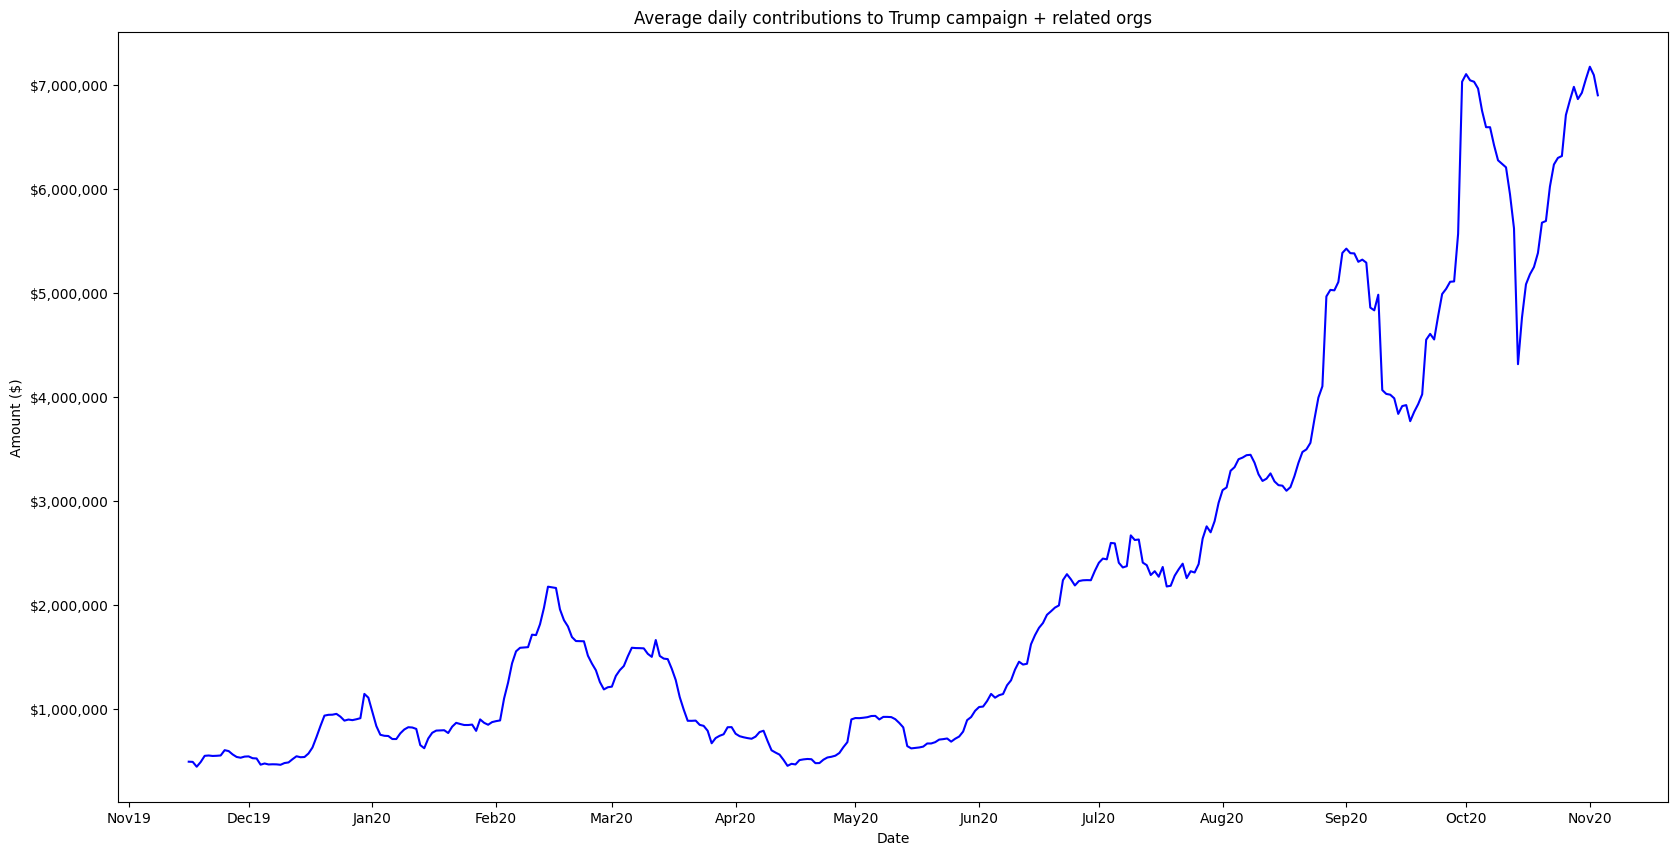

In [4]:
# Bucket contributions by day -- for each day, compute total $ and also # of contributors
import typing as t
from collections import defaultdict

contributions_by_day: dict[datetime.date, tuple[float, int]] = defaultdict(lambda: (0.0, 0))
for date, amount_usd in contributions:
  total_amount_usd, num_contributors = contributions_by_day[date]
  total_amount_usd += amount_usd
  num_contributors += 1
  contributions_by_day[date] = (total_amount_usd, num_contributors)

# Sort contributions by date (earliest to latest)
contributions_by_day = dict(sorted(contributions_by_day.items(), key=lambda x: x[0]))

# Create a pandas dataframe -- split the tuple into two columns
import pandas as pd
df = pd.DataFrame(contributions_by_day.items(), columns=["date", "amount_and_num_contributors"])
df["amount_usd"] = df["amount_and_num_contributors"].apply(lambda x: x[0])
df["num_contributors"] = df["amount_and_num_contributors"].apply(lambda x: x[1])
df = df.drop(columns=["amount_and_num_contributors"])

# Export to un-smoothed data to CSV
df.to_csv("../data/fec/trump-contributions.csv", index=False)

# Smooth the data by averaging over a 14-day window
df["amount_usd"] = df["amount_usd"].rolling(14).mean()
df["num_contributors"] = df["num_contributors"].rolling(14).mean()

# Export to smoothed data to CSV
df.to_csv("../data/fec/trump-contributions-smoothed.csv", index=False)

# Plot the data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(df["date"], df["amount_usd"], color="blue")
ax.set_ylabel("Amount ($)")
ax.set_xlabel("Date")
ax.set_title("Average daily contributions to Trump campaign + related orgs")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b%y"))
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.0f}"))
plt.show()

There seems to be a very strong day-of-week behavior in this data. What day of the week tends to get the most donations?  What day of the week gets the least?

In [5]:
# For each of the seven days of the week, compute the average contribution amount and number of contributors
import datetime
from collections import defaultdict

contributions_by_day_of_week: dict[int, tuple[float, int]] = defaultdict(lambda: (0.0, 0))
for date, amount_usd in contributions:
  day_of_week = date.weekday()
  total_amount_usd, num_contributors = contributions_by_day_of_week[day_of_week]
  total_amount_usd += amount_usd
  num_contributors += 1
  contributions_by_day_of_week[day_of_week] = (total_amount_usd, num_contributors)

# Sort by total amount
contributions_by_day_of_week = dict(sorted(contributions_by_day_of_week.items(), key=lambda x: x[1][0], reverse=True))

# Print the results
print("Total contribution amount and number of contributors by day of week:")
for day_of_week, (total_amount_usd, num_contributors) in contributions_by_day_of_week.items():
  print(f"Day of week: {datetime.date(2020, 1, 5 + day_of_week).strftime('%A')}")
  print(f"Total amount: ${total_amount_usd:,.0f}")
  print(f"Number of contributors: {num_contributors:,}")
  print()


Total contribution amount and number of contributors by day of week:
Day of week: Wednesday
Total amount: $161,012,322
Number of contributors: 681,269

Day of week: Tuesday
Total amount: $151,017,811
Number of contributors: 455,388

Day of week: Monday
Total amount: $144,876,267
Number of contributors: 569,566

Day of week: Sunday
Total amount: $144,184,851
Number of contributors: 569,689

Day of week: Thursday
Total amount: $127,695,607
Number of contributors: 473,655

Day of week: Friday
Total amount: $47,573,911
Number of contributors: 203,749

Day of week: Saturday
Total amount: $45,394,266
Number of contributors: 232,870

